<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/InceptionV3/Alzheimer_model_inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install /content/drive/MyDrive/AI/brainy-1.1.tar.gz

In [ ]:
import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
import os

import zipfile

from google.colab import drive

gdrive = '/content/drive'

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'smallpreprocessed'

archive_path = os.path.join(gdisk, filename)

with zipfile.ZipFile('/content/drive/MyDrive/AI/smallpreprocessed.zip', 'r') as zip_ref:

 zip_ref.extractall(f'{filename}')

In [ ]:
import os

import zipfile

from google.colab import drive

gdrive = '/content/drive'

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'smallpreprocessed'

archive_path = os.path.join(gdisk, filename)

with zipfile.ZipFile('/content/drive/MyDrive/AI/smallpreprocessed.zip', 'r') as zip_ref:

 zip_ref.extractall(f'{filename}')

In [ ]:
dataset_dir = '/content/smallpreprocessed/data/SmallPreprocessed'
image_height = 299
image_width = 299
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'val'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

for ds in [train_ds, test_ds, val_ds]:
    ds.cache()
    ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow import keras

# Load InceptionV3 with all layers frozen
model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299, 3)
)

# Freeze all layers
for layer in model.layers:
    layer.trainable = False

In [ ]:
from tensorflow import keras
import tensorflow as tf

# Image dimensions
image_height = 299
image_width = 299
input_shape = (image_height, image_width, 3)

# Input layer
inputs = keras.Input(shape=input_shape)

# Skip augmentation — direct input
x = inputs

# Load InceptionV3 base model with pretrained weights
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg'  # Outputs a global average pooled vector
)
base_model.trainable = False  # Freeze pretrained weights

# Pass input through base model
x = base_model(x)

# Custom classification head
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)  # 4 classes

# Combine into a full model
model = keras.Model(inputs=inputs, outputs=outputs)

# Show model summary
model.summary()


In [ ]:
for layer in model.layers[-50:]:
    layer.trainable = True

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Checkpoint - save only the best model
checkpoint_cb = ModelCheckpoint(
    "model_InceptionV3.keras",  # Updated filename
    save_best_only=True
)

# Early Stopping - stop if no improvement for 10 epochs
early_stopping_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
EPOCHS = 25

In [ ]:
# Now train with class weights
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb],
    # class_weight=class_weights
)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 274s 260ms/step - accuracy: 0.5609 - loss: 1.2806 - val_accuracy: 0.7195 - val_loss: 0.8798
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 178s 237ms/step - accuracy: 0.8113 - loss: 0.4743 - val_accuracy: 0.7595 - val_loss: 0.6989
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 179s 238ms/step - accuracy: 0.9170 - loss: 0.2247 - val_accuracy: 0.7535 - val_loss: 0.8376
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 179s 238ms/step - accuracy: 0.9527 - loss: 0.1331 - val_accuracy: 0.9245 - val_loss: 0.2489
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 181s 241ms/step - accuracy: 0.9546 - loss: 0.1210 - val_accuracy: 0.9240 - val_loss: 0.2164
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 180s 240ms/step - accuracy: 0.9661 - loss: 0.0893 - val_accuracy: 0.9280 - val_loss: 0.2033
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 201s 239ms/step - accuracy: 0.9664 - loss: 0.0945 - val_accuracy: 0.9470 - val_loss: 0.1508
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 178s 238ms/step - accuracy: 0.9776 -

In [ ]:
for layer in model.layers[-10:]:
    layer.trainable = True

In [ ]:
# Now train with class weights
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb],
    # class_weight=class_weights
)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 175s 234ms/step - accuracy: 0.9919 - loss: 0.0261 - val_accuracy: 0.9865 - val_loss: 0.0433
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 178s 238ms/step - accuracy: 0.9904 - loss: 0.0269 - val_accuracy: 0.9845 - val_loss: 0.0470
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 175s 233ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9850 - val_loss: 0.0478
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 202s 233ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 0.9820 - val_loss: 0.0614
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 202s 233ms/step - accuracy: 0.9874 - loss: 0.0435 - val_accuracy: 0.9765 - val_loss: 0.0638
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 175s 233ms/step - accuracy: 0.9952 - loss: 0.0169 - val_accuracy: 0.9790 - val_loss: 0.0639
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 178s 237ms/step - accuracy: 0.9965 - loss: 0.0138 - val_accuracy: 0.9845 - val_loss: 0.0466
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 202s 237ms/step - accuracy: 0.9959 -

In [ ]:
model.save('/content/model_InceptionV3.keras')
model.export('/content/models/inceptionV3_model')

Saved artifact at '/content/models/inceptionV3_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132657942886544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657856426832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657856427984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657942886928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657856429904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657856428944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657856429136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657856429520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657855054288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132657855054480: TensorSpec(shape=(), dtype=tf.resource, name=N

In [ ]:
hist_=pd.DataFrame(history.history)

In [ ]:
score, acc= model.evaluate(test_ds)
print('Val Loss =', score)
print('Val Accuracy =', acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9961 - loss: 0.0106
Val Loss = 0.026260925456881523
Val Accuracy = 0.9915000200271606


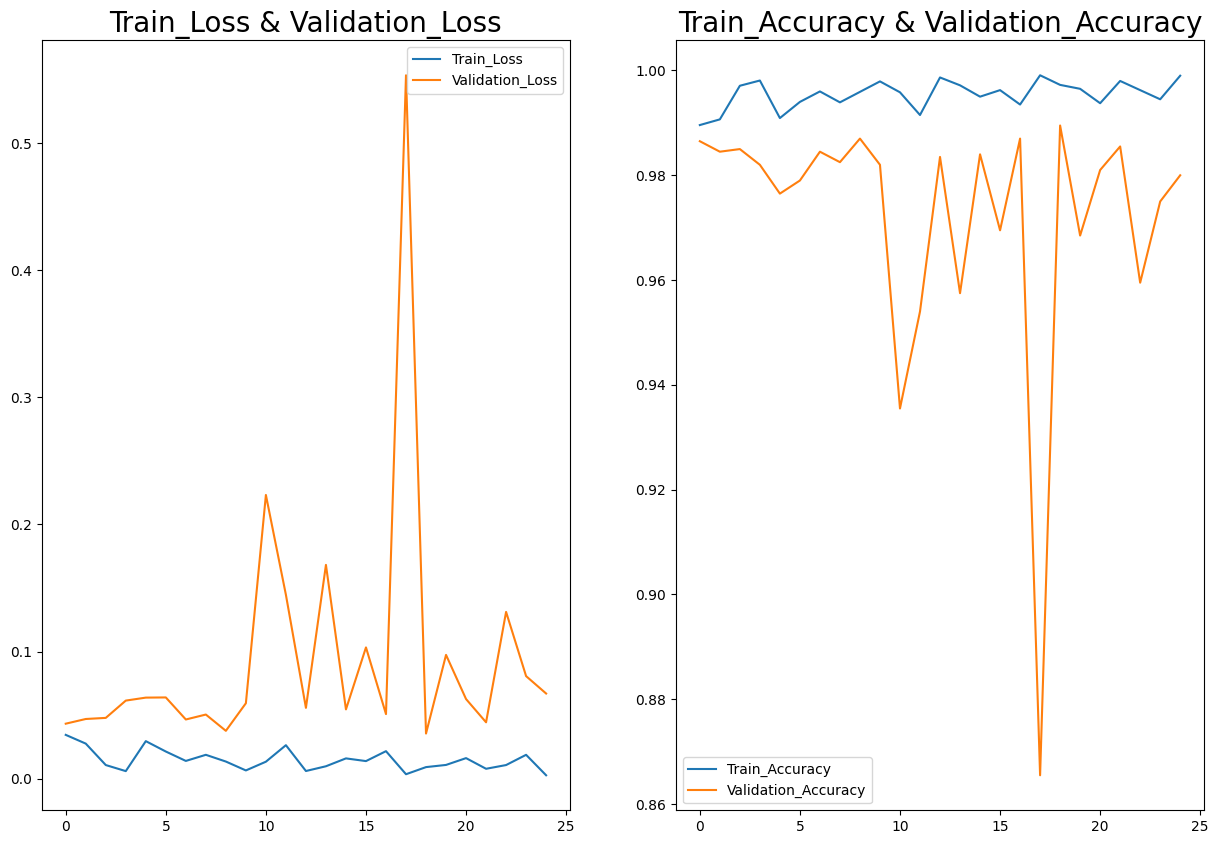

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Convert test labels (one-hot) to class indices
y_test_labels = []
for batch in test_ds:
    images, labels = batch
    y_test_labels.append(labels.numpy())

y_test = np.concatenate(y_test_labels, axis=0)
y_test = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Predict using model
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)  # Class index

# Create a DataFrame with Actual vs Prediction
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})


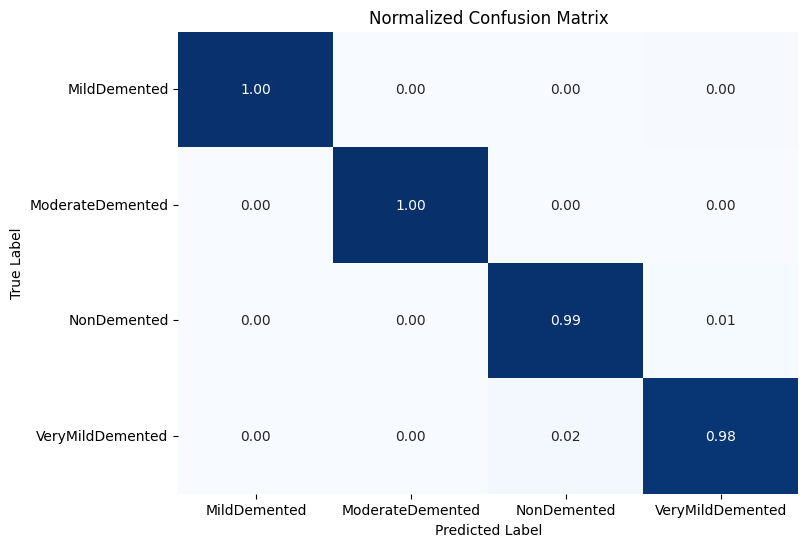

array([[498,   0,   0,   2],
       [  0, 500,   0,   0],
       [  1,   0, 495,   4],
       [  0,   0,  10, 490]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure your predicted and true labels are available
# y_test and y_pred should be 1D arrays of class indices

# Define class labels (update to match your actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Compute the confusion matrix
CM = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM_percent,
            fmt='.2f',
            annot=True,
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Optionally print the raw CM
CM


In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_names)
print('Classification Report is : ', ClassificationReport)